In [1]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import numpy as np
import pandas as pd
import pathlib
import cv2
import itertools
import random 

from torchvision import datasets
from torch import optim
from scipy.sparse import lil_matrix, csr_matrix
from scipy.optimize import linprog
from matplotlib import pyplot as plt

In [2]:
root = "../../OT-ICNN-bias/data/celeba/"
IMAGE_FOLDER_PATH = root + "Img_folder"
ATTRIBUTES_PATH = root + "list_attr_celeba.csv"

In [3]:
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [4]:
celeba = datasets.ImageFolder(IMAGE_FOLDER_PATH)

In [5]:
df = pd.read_csv(ATTRIBUTES_PATH)
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [6]:
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [7]:
df1 = df.sample(60000)
df1.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
154526,154527.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
84443,084444.jpg,-1,-1,-1,1,-1,-1,-1,1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
187197,187198.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
32159,032160.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,1,-1,-1,1
125586,125587.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,-1


In [8]:
df2 = df.sample(60000)
df2.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
141602,141603.jpg,-1,-1,-1,-1,-1,1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,-1
8294,008295.jpg,-1,-1,1,-1,-1,-1,-1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1
166454,166455.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
194568,194569.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,1,-1,1,1,-1,1
137848,137849.jpg,-1,1,1,-1,-1,-1,1,1,-1,...,-1,1,-1,1,1,-1,1,1,-1,1


In [8]:
df1["to_invert"] = [1]*1000 + [-1]*59000

In [9]:
df1["image_id"]

154526    154527.jpg
84443     084444.jpg
187197    187198.jpg
32159     032160.jpg
125586    125587.jpg
             ...    
138885    138886.jpg
92703     092704.jpg
154714    154715.jpg
133039    133040.jpg
92478     092479.jpg
Name: image_id, Length: 60000, dtype: object

In [25]:
def compute_hist(img):
    b_hist = cv2.calcHist(cv2.split(img), [0], mask = None, histSize = [256], ranges = [0,256])
    g_hist = cv2.calcHist(cv2.split(img), [1], mask = None, histSize = [256], ranges = [0,256])
    r_hist = cv2.calcHist(cv2.split(img), [2], mask = None, histSize = [256], ranges = [0,256])

    hists = np.concatenate((b_hist,g_hist,r_hist), axis = 1)

    return hists

In [26]:
def extract_hist(df, negative = False):  
    data = list()
    i = 0
    for image_path in df["image_id"]:
        img = cv2.imread(IMAGE_FOLDER_PATH + "/Img/" + image_path)
        if negative and i<1000:
            img = ~img
            i += 1
        data.append(compute_hist(img))
        
    return np.array(data)

In [27]:
torch.save(torch.from_numpy(extract_hist(df1)), root + "/celebA__hist_sample1.pt")

In [28]:
torch.save(torch.from_numpy(extract_hist(df1, negative = True)), root + "/celebA__hist_sample2.pt")

In [29]:
df1.to_csv(root + "/celebA_sample1.csv")

In [16]:
df2.to_csv(root + "/celebA_sample2.csv")

## After Experiment

In [16]:
df2 = pd.read_csv(root + "/celebA_sample1.csv")

df2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,to_invert,results_Toy_exp
0,0,0,141602,141603.jpg,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,1,149846832.0
1,1,1,8294,008295.jpg,-1,-1,1,-1,-1,-1,...,-1,1,1,-1,1,-1,-1,1,1,465139680.0
2,2,2,166454,166455.jpg,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1,1,243672272.0
3,3,3,194568,194569.jpg,-1,1,1,-1,-1,-1,...,-1,-1,1,-1,1,1,-1,1,1,134786048.0
4,4,4,137848,137849.jpg,-1,1,1,-1,-1,-1,...,-1,1,1,-1,1,1,-1,1,1,173205088.0


In [17]:
df2=df2.sort_values(by = "results_Toy_exp", ascending = False)

In [18]:
df2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,to_invert,results_Toy_exp
46377,46377,46377,114237,114238.jpg,-1,-1,1,-1,-1,1,...,1,-1,-1,-1,1,-1,-1,1,-1,1.318588e+09
10452,10452,10452,174543,174544.jpg,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.259276e+09
3904,3904,3904,133089,133090.jpg,-1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1.257298e+09
46990,46990,46990,129614,129615.jpg,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,-1,1.253162e+09
12481,12481,12481,144060,144061.jpg,-1,-1,-1,1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1.133145e+09


In [19]:
df2["to_invert"][:10000].sum()

-9968

In [20]:
df2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,to_invert,results_Toy_exp
46377,46377,46377,114237,114238.jpg,-1,-1,1,-1,-1,1,...,1,-1,-1,-1,1,-1,-1,1,-1,1.318588e+09
10452,10452,10452,174543,174544.jpg,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.259276e+09
3904,3904,3904,133089,133090.jpg,-1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1.257298e+09
46990,46990,46990,129614,129615.jpg,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,-1,1.253162e+09
12481,12481,12481,144060,144061.jpg,-1,-1,-1,1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1.133145e+09


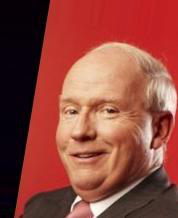

In [24]:
from PIL import Image

image_path = df2["image_id"][3904]
img = Image.open(IMAGE_FOLDER_PATH + "/Img/" + image_path)

img

In [27]:
df2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,to_invert,results_Toy_exp
38539,38539,38539,71017,071018.jpg,1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,-1,1.326037e+09
59226,59226,59226,37177,037178.jpg,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.268262e+09
372,372,372,162293,162294.jpg,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1,-1,1.224986e+09
46699,46699,46699,60829,060830.jpg,1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1,-1,1.219322e+09
2685,2685,2685,197671,197672.jpg,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,-1,1.186825e+09
